## Projeto para prever Churn de clientes em Telecomunicação

#### Descrição do Problema

O setor de telecomunicações é um setor em rápido crescimento que está em constante evolução para atender às demandas dos consumidores. À medida que a tecnologia avança e o comportamento do usuário muda, as operadoras de telecomunicações enfrentam uma variedade de desafios que podem impactar o sucesso de seus negócios. Para permanecerem competitivas e atender às necessidades dos clientes, é importante que as empresas de telecomunicações analisem regularmente seus dados para identificar problemas relevantes e oportunidades de melhoria.

#### Objetivo do Projeto

O objetivo é desenvolver um modelo de Machine Learning que possa prever quais clientes provavelmente abandonarão ou descontinuarão o uso do serviço. A previsão de rotatividade é um problema comercial crítico para empresas que operam em um modelo de assinatura ou receita recorrente, como empresas de telecomunicações.

Diminuir o número de falsos negativos e aumentar a presença de verdadeiros positivos resultará em um saldo positivo para a empresa, explico na solução abaixo.<br>

#### Solução

Na área de Machine Learning temos métricas para avaliar a performance do modelo. Para este projeto de previsão de cancelamento de serviço a métrica **recall** é de suma importância. A métrica analisa justamente o erro do modelo nos clientes que já cancelaram o serviço anteriormente.

Os **Verdadeiros Positivos** são os clientes que o modelo treinado com dados históricos previu que irão cancelar e realmente cancelaram. Essa análise pode resultar na prevenção de possíveis clientes que cancelaram seus planos e com isso tentar revertê-los.

Os **Falso Negativos** são os clientes que o modelo treinado com dados históricos não conseguir prever o cancelamento do serviço, resultado em perda do cliente para a empresa e sua receita associada. Selecionar um modelo que consegue identificar e reduzir esses clientes é o objetivo do projeto.

**Tópicos do projeto:**

- Divisão entre os dados de Treinamento e Teste
- Análise Exploratória dos Dados
- Pré-processamento
- Treinamento de 4 modelos com validação cruzada estratificada
- Otimização de Hiperparâmetros para métrica Recall utilizando o Optuna
- Previsão nos dados de Teste
- Avaliação do Desempenho do Modelo e a importância de cada variável
- Conversão de Machine Learning para Resultados Financeiros
- Conclusão


In [1]:
# Manipulação dos dados
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import analysis_plots, classification_kfold_cv, plot_classification_kfold_cv, evaluate_classifier
from utils import plot_probability_distributions, save_object, plot_feature_importances

# Modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import optuna

# Configuraçoes
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette))

pd.set_option('display.max_column', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/telecom_data.csv')
df.shape

(7043, 21)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- São 7.043 observações e 21 colunas.
- Como codigo de ética vou remover a variável ``gender`` do conjunto.

In [5]:
df.drop('gender', axis=1, inplace=True)

### Divisão entre os dados de Treinamento e Teste

In [7]:
features = df.drop('Churn', axis=1)
target = df['Churn'].copy()

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=43)

In [8]:
print(f'Shape dos dados de Treino: {features_train.shape}.')
print(f'Shape dos dados de Teste: {features_test.shape}.')

Shape dos dados de Treino: (5634, 19).
Shape dos dados de Teste: (1409, 19).


In [9]:
print('Proporção da quantidade de Churn em Treino: ')
print(f'{target_train.value_counts(normalize=True)}')
print('\nProporção da quantidade de Churn em Teste: ')
print(f'{target_test.value_counts(normalize=True)}')

Proporção da quantidade de Churn em Treino: 
Churn
No     0.734647
Yes    0.265353
Name: proportion, dtype: float64

Proporção da quantidade de Churn em Teste: 
Churn
No     0.734564
Yes    0.265436
Name: proportion, dtype: float64


### Análise Exploratória

In [10]:
df_train = pd.merge(features_train, target_train, how='inner', left_index=True, right_index=True)
df_test = pd.merge(features_test, target_test, how='inner', left_index=True, right_index=True)

In [11]:
# Valores Ausentes
print('Conjunto de Treino:', df_train.isnull().sum().any())
print('Conjunto de Teste:', df_test.isnull().sum().any())

Conjunto de Treino: False
Conjunto de Teste: False


In [12]:
# Valores Duplicados
print('Conjunto de Treino:', df_train.duplicated().sum())
print('Conjunto de Teste:', df_test.duplicated().sum())

Conjunto de Treino: 0
Conjunto de Teste: 0


#### Variável Target

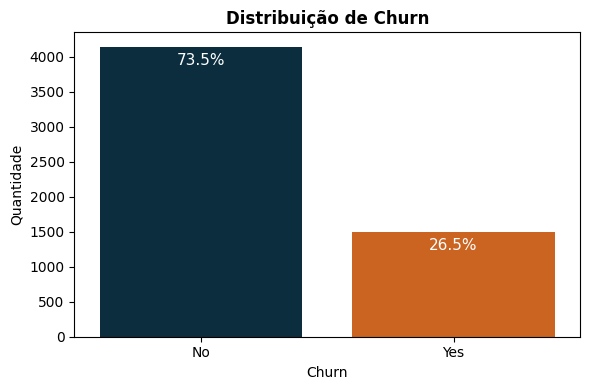

In [14]:
# Countplot da Variável Churn
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_train, x='Churn', palette=color_palette)

# Calcular e adicionar as porcentagens
total = len(df_train)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), 
                xytext=(0, -10), textcoords="offset points", 
                ha='center', va='center', fontsize=11, color='white')

# Título e labels
plt.title('Distribuição de Churn', fontweight='bold')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

A variável está desequilibrada. 26,5% dos clientes realizaram o cancelamento. Será necessário adotar algumas estratégias para lidar com isso.

- Stratified K-fold com validação cruzada para manter a proporção quando em treino e validação, mesmo para ajuste de hiperparâmetros.
- Se necessário vou realizar a técnica de sampling nos dados utilizando a biblioteca imbalanced_learn.

#### Variáveis Categóricas

In [12]:
categorical_features = [col for col in df_train.select_dtypes('object').columns.to_list() if col != 'customerID' and col != 'Churn']
print(f'São {len(categorical_features)} variáveis categóricas.')
print('São elas: ')
print(categorical_features)

São 15 variáveis categóricas.
São elas: 
['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


**Todas as variáveis categóricas são nominais!**

In [13]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {df_train[feature].nunique()} unique values. They are: ')
    print(df_train[feature].value_counts(normalize=True))
    print()

Partner
----------------------------------------
There are 2 unique values. They are: 
Partner
No     0.516329
Yes    0.483671
Name: proportion, dtype: float64

Dependents
----------------------------------------
There are 2 unique values. They are: 
Dependents
No     0.700213
Yes    0.299787
Name: proportion, dtype: float64

PhoneService
----------------------------------------
There are 2 unique values. They are: 
PhoneService
Yes    0.902023
No     0.097977
Name: proportion, dtype: float64

MultipleLines
----------------------------------------
There are 3 unique values. They are: 
MultipleLines
No                  0.474086
Yes                 0.427938
No phone service    0.097977
Name: proportion, dtype: float64

InternetService
----------------------------------------
There are 3 unique values. They are: 
InternetService
Fiber optic    0.445509
DSL            0.339013
No             0.215477
Name: proportion, dtype: float64

OnlineSecurity
----------------------------------------


Observações:

- Nenhuma variável categórica apresenta alta cardinalidade.
- A variável ``TotalCharges`` está com o tipo de dados object porém contém valores numéricos.
- Tentei converter a variável para o tipo numérico e deu o seguinte erro: could not convert string to float: ' '.
- Encontrei 10 observações/linhas com valor ' ' na variável ``TotalCharges``.
- 9 dos 10 são de contratos de dois anos.
- Tenho 2 opções: A primeira seria remover essas observações. A segunda seria imputar a média dos valores de contratos de 2 anos para essas observações.
- Decidi remover essas observações para evitar o enviezamento nos dados e por se tratar de uma quantia muito baixa.

In [24]:
#df_train['TotalCharges'] = df_train['TotalCharges'].astype(float)

In [14]:
df_train[df_train["TotalCharges"] == ' '].head(6)

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
5218,2923-ARZLG,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
753,3115-CZMZD,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
6754,2775-SEFEE,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
936,5709-LVOEQ,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No


In [15]:
df_train[(df_train['Contract'] == 'Two year') & (df_train['TotalCharges'] != ' ')]['TotalCharges'].astype(float).mean()

3789.8074981160516

In [16]:
# Removendo as observaçoes selecionadas
index_remove = [488, 5218, 6670, 753, 6754, 936, 4380, 3826, 1082, 3331]
df_train.drop(index_remove, inplace=True)

In [17]:
# Convertendo o tipo de dado da variável TotalCharges
df_train['TotalCharges'] = df_train['TotalCharges'].astype(float)
categorical_features.remove('TotalCharges')

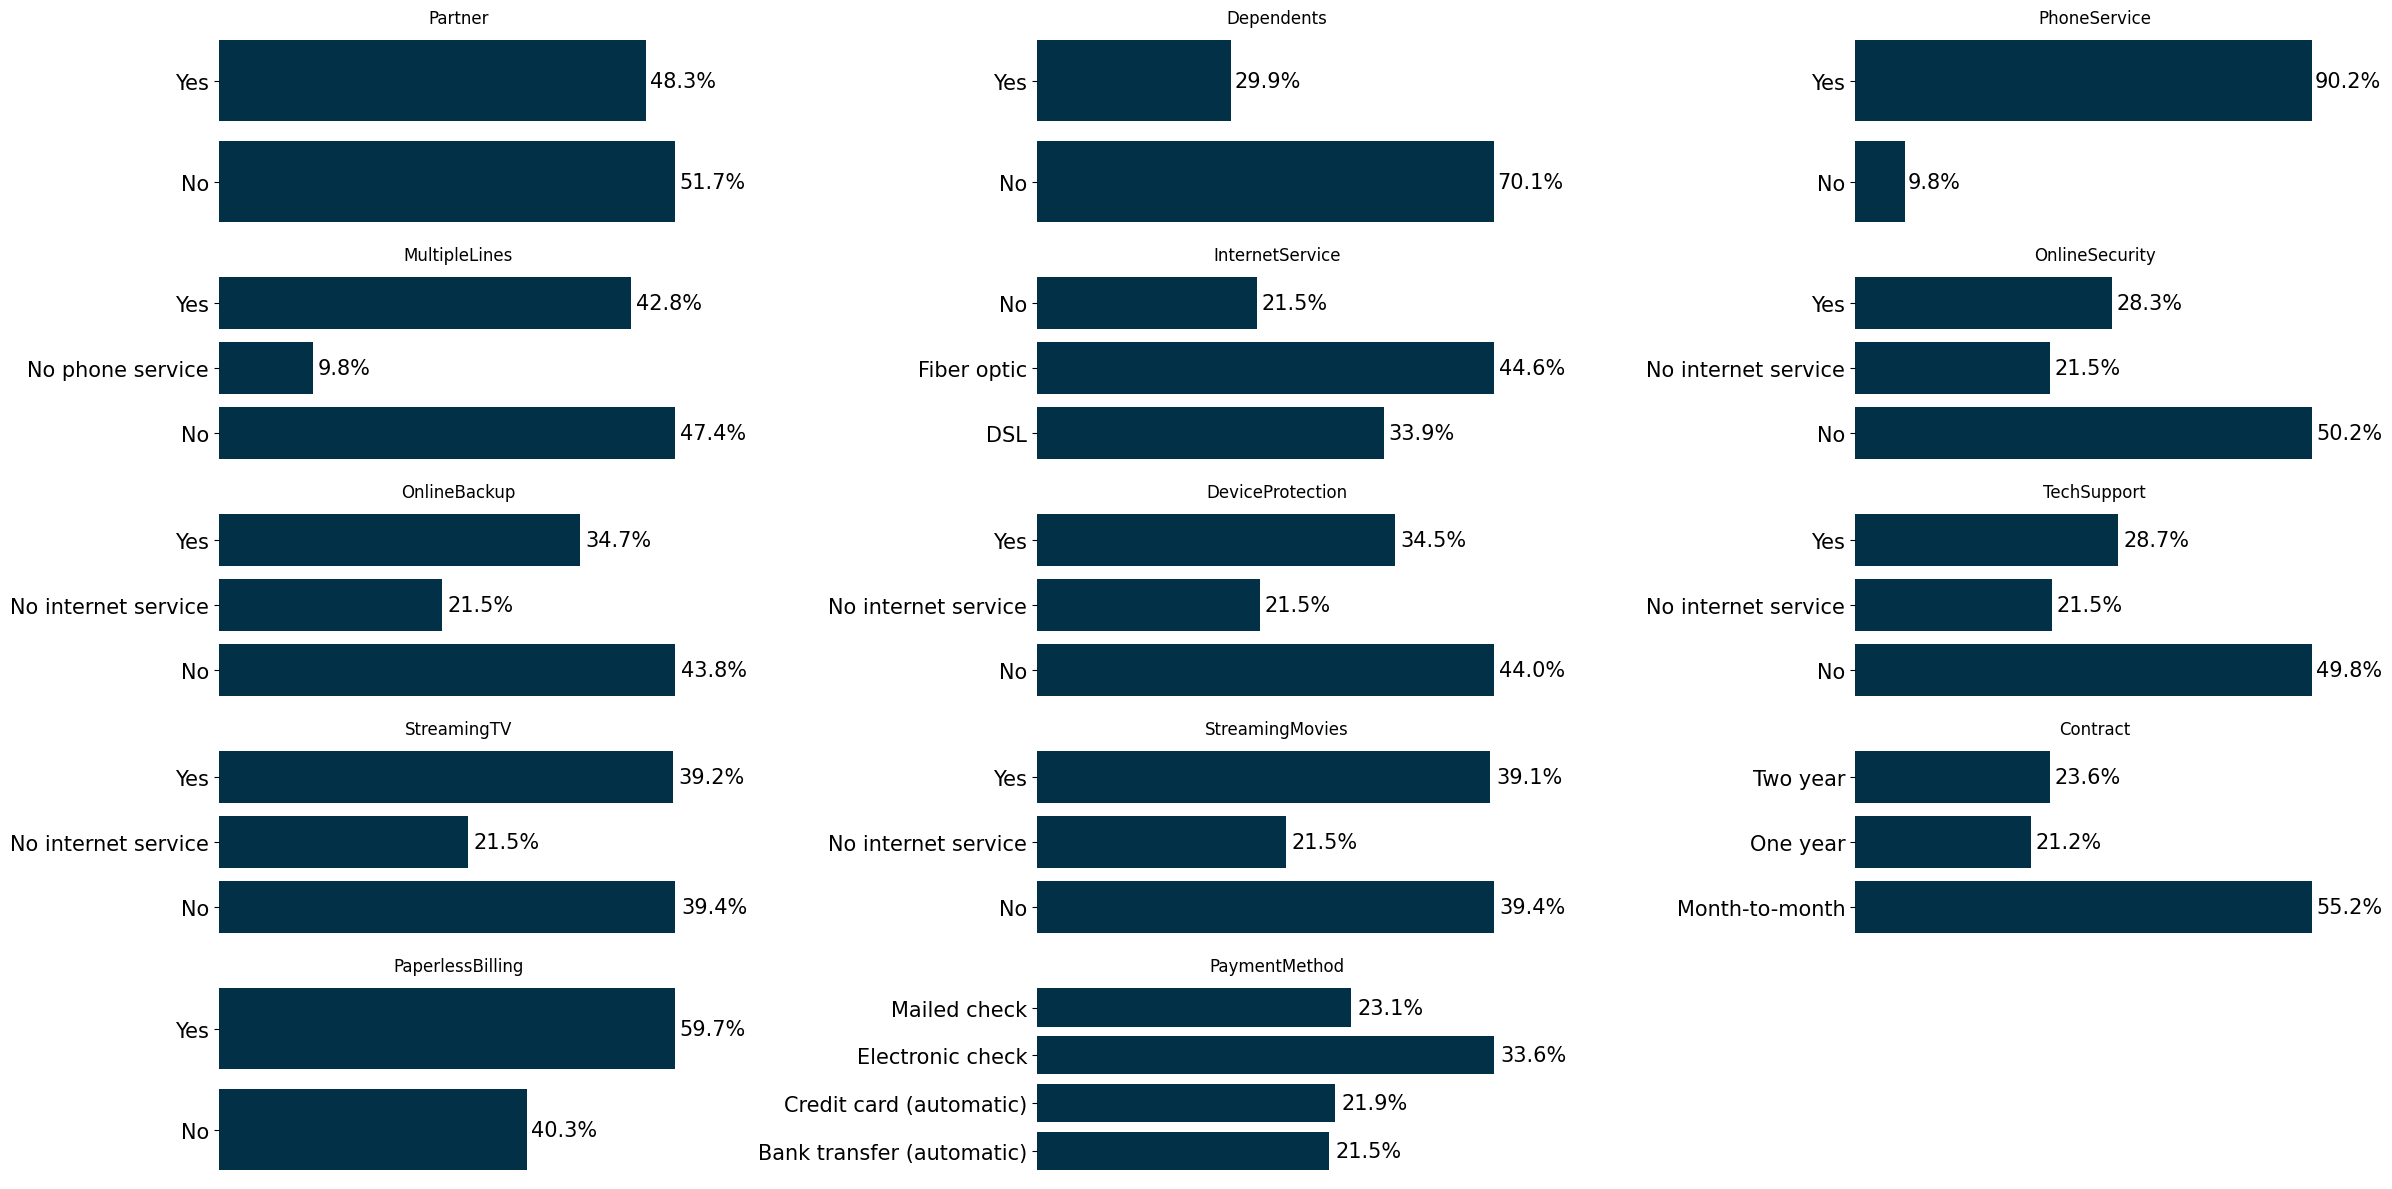

In [18]:
analysis_plots(data=df_train, features=categorical_features, barplot=True, figsize=(24, 12))

#### Variável Numéricas

In [19]:
numerical_cols = [col for col in df_train.select_dtypes(exclude='object').columns.to_list() if col != 'SeniorCitizen']
df_train[numerical_cols].head(7)

,tenure,MonthlyCharges,TotalCharges
2027,24,20.15,456.85
1545,63,104.75,6536.50
2940,53,54.45,2854.55
6219,1,25.70,25.70
2618,25,19.90,505.45
6642,25,79.00,1902.00
2610,39,30.10,1131.30


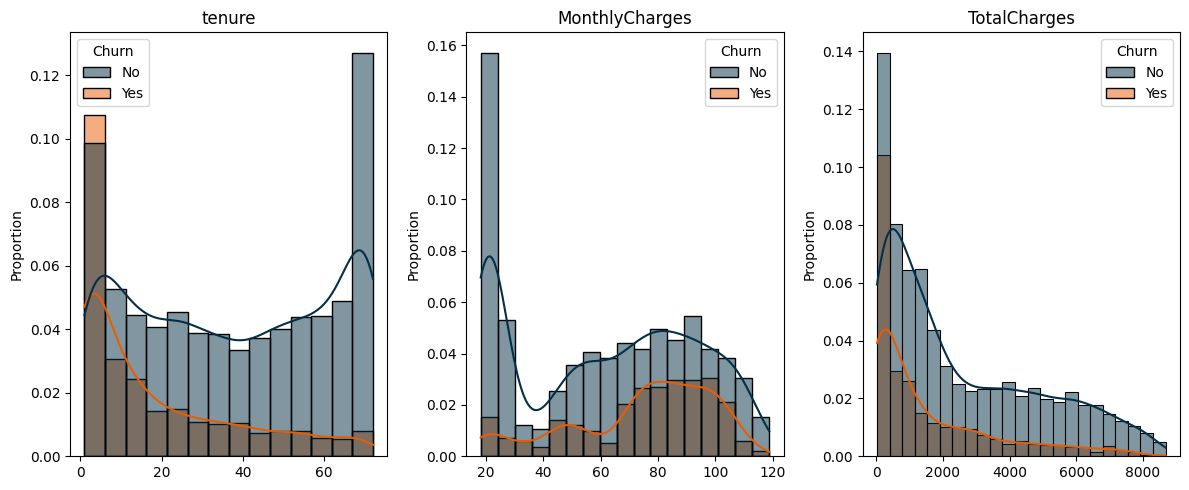

In [20]:
analysis_plots(data=df_train, features=numerical_cols, histplot=True, kde=True, hue='Churn', figsize=(12, 5))

Observações:

- Na variável ``tenure`` que significa quantos meses a pessoa é cliente, podemos observar os primeiros meses são críticos para manter esse cliente.
- Na variável ``MonthlCharges`` podemos notar que clientes que pagam entre 65 dólares e 110 dólares apresentam uma maior probabilidade de cancelamento.
- Na variável ``TotalCharges`` temos o indicativo que pessoas que gastaram menos com a empresa apresentam uma maior probabilidade de cancelamento.


### Pre-processamento

In [21]:
# Conjunto de Treino
df_train.drop('customerID', axis=1, inplace=True)
df_train['Churn'].replace({'No': 0, 'Yes': 1}, inplace=True)
df_train = pd.get_dummies(df_train, drop_first=True, dtype=float)

# Divisão Features e Target
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn'].copy()

In [22]:
# Conjunto de Teste
df_test.drop('customerID', axis=1, inplace=True)
df_test['Churn'].replace({'No': 0, 'Yes': 1}, inplace=True)
df_test.drop(1340, inplace=True) # TotalCharges = ' '
df_test['TotalCharges'] = df_test['TotalCharges'].astype(float)
df_test = pd.get_dummies(df_test, drop_first=True, dtype=float)

# Divisão Features e Target
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn'].copy()

### Modelagem - Machine Learning

In [23]:
tree_models = {
              'Decision Tree': DecisionTreeClassifier(random_state=43),
              'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=43),
              'Gradient Boost': GradientBoostingClassifier(random_state=43),
              'LightGBM': LGBMClassifier(n_jobs=-1, random_state=43)
}

#### Cross Validation - Stratified KFold

Decision Tree results: 
--------------------------------------------------
Training score: 0.995744432681474
Average validation score: 0.651198057653474
Standard deviation: 0.008473473155689585
Average F1 Score: 0.48584188459577166
Average Recall Score: 0.49230769230769234
Training time: 0.054 seconds

Random Forest results: 
--------------------------------------------------
Training score: 0.9970245534683707
Average validation score: 0.8165290131141273
Standard deviation: 0.0038262497167118794
Average F1 Score: 0.5457720162749823
Average Recall Score: 0.48361204013377923
Training time: 0.32901 seconds

Gradient Boost results: 
--------------------------------------------------
Training score: 0.7406407569916998
Average validation score: 0.8389313369018602
Standard deviation: 0.0046352778770235616
Average F1 Score: 0.571314257329836
Average Recall Score: 0.5063545150501672
Training time: 1.11103 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[

,model,avg_val_score,train_score,avg_f1_score,avg_recall_score
0,Gradient Boost,0.838931,0.740641,0.571314,0.506355
1,LightGBM,0.825260,0.816578,0.557101,0.505686
2,Random Forest,0.816529,0.997025,0.545772,0.483612
3,Decision Tree,0.651198,0.995744,0.485842,0.492308


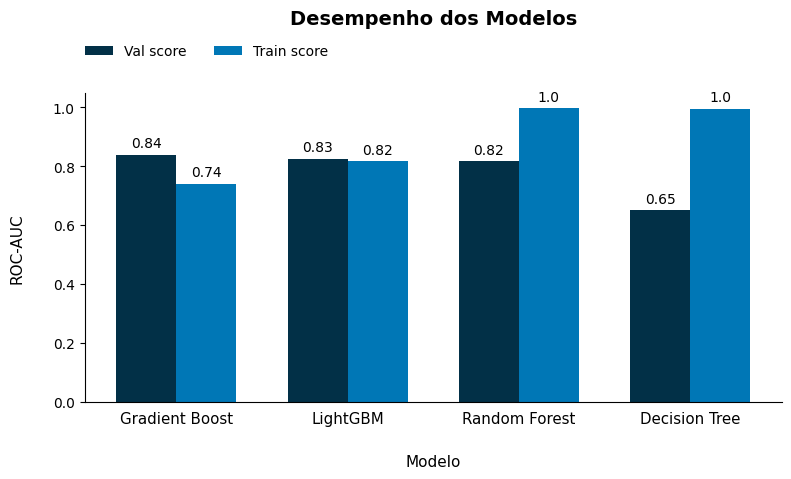

In [24]:
# Treinamento do modelo com validação cruzada
eval_df = classification_kfold_cv(models=tree_models, X_train=X_train, y_train=y_train, n_folds=5)
plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)
eval_df

Observações:

- Os modelos RandomForest e DecisionTree sofreram de overfitting e apresentaram os menores recalls.
- O modelo GradientBoost obteve a melhor performance nos dados de validação, f1 score e empate com o LightGBM no recall.
- O modelo LightGBM apresentou o melhor equilíbrio entre os dados de teste e validação e com empate no recall.

Vou selecionar o modelo LightGBM para otimização dos hiperparâmetros.


### Otimização de Hiperparâmetros - Optuna

#### Otimização Métrica Recall

In [26]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'recall',
        'n_estimators': 3000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    
    # Obtain average stratified k-fold cross validation recall score.
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
    val_scores = cross_val_score(model, X_train, y_train, scoring='recall', cv=stratified_kfold)
    avg_recall = val_scores.mean()
    
    return avg_recall

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-10-22 16:24:32,566] A new study created in memory with name: no-name-762b0ffe-40b2-4bab-a78c-ffa0398086d9
[I 2024-10-22 16:25:03,686] Trial 0 finished with value: 0.5973244147157191 and parameters: {'learning_rate': 0.005080805759246017, 'num_leaves': 564, 'subsample': 0.2587376474671579, 'colsample_bytree': 0.8036398096252051, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.5973244147157191.
[I 2024-10-22 16:25:16,953] Trial 1 finished with value: 0.7531772575250836 and parameters: {'learning_rate': 0.002163933055908699, 'num_leaves': 496, 'subsample': 0.9697945372498831, 'colsample_bytree': 0.6780218190175599, 'min_data_in_leaf': 83}. Best is trial 1 with value: 0.7531772575250836.
[I 2024-10-22 16:25:22,846] Trial 2 finished with value: 0.7431438127090301 and parameters: {'learning_rate': 0.016466605166135215, 'num_leaves': 522, 'subsample': 0.1481459380964551, 'colsample_bytree': 0.08751872400854985, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.7531772575250

Best Hyperparameters: {'learning_rate': 0.0016724808356654256, 'num_leaves': 228, 'subsample': 0.3432865436986795, 'colsample_bytree': 0.2525574890616741, 'min_data_in_leaf': 71}


### Modelo Final e Predict nos dados de Teste

In [27]:
best_params = {'objective': 'binary',
               'metric': 'recall',
               'n_estimators': 3000,
               'verbosity': -1,
               'bagging_freq': 1,
               'class_weight': 'balanced', 
               'learning_rate': 0.0016724808356654256,
               'num_leaves': 228,
               'subsample': 0.3432865436986795,
               'colsample_bytree': 0.2525574890616741,
               'min_data_in_leaf': 71}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.2525574890616741,
               learning_rate=0.0016724808356654256, metric='recall',
               min_data_in_leaf=71, n_estimators=3000, num_leaves=228,
               objective='binary', subsample=0.3432865436986795, verbosity=-1)

In [28]:
y_pred = lgb_clf.predict(X_test)

In [29]:
churn_probas = lgb_clf.predict_proba(X_test)[:, 1]

#### Avalição do Desempenho do Modelo Final

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1034
           1       0.56      0.82      0.67       374

    accuracy                           0.78      1408
   macro avg       0.74      0.79      0.75      1408
weighted avg       0.83      0.78      0.79      1408



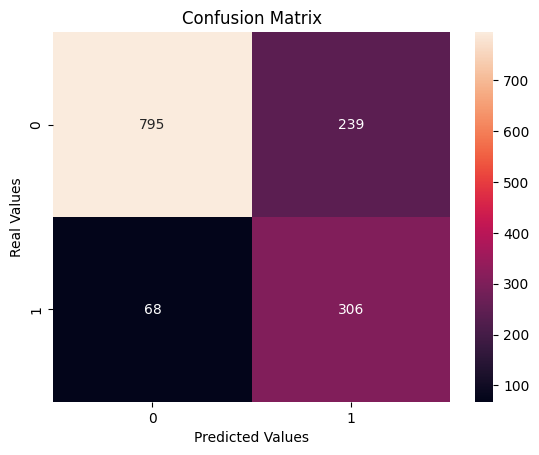

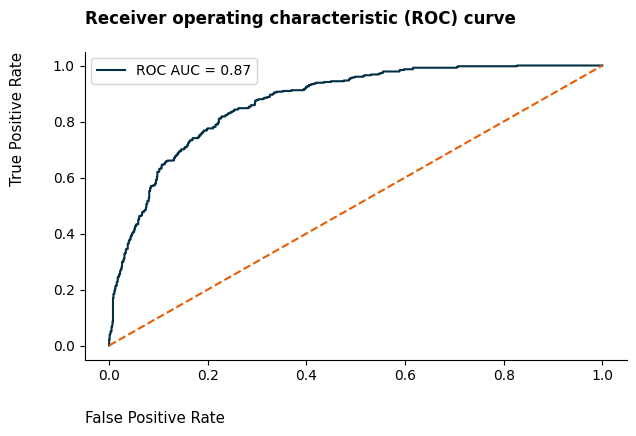

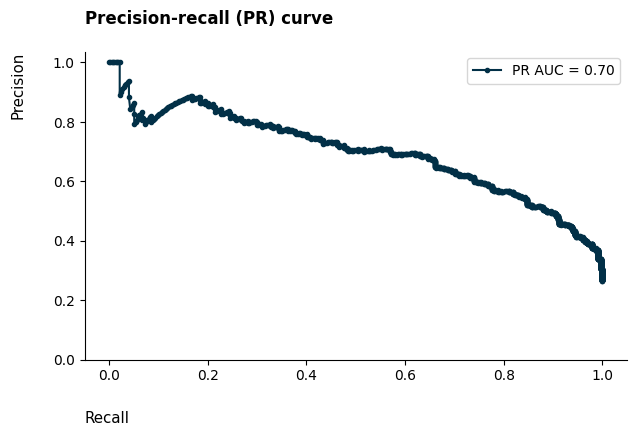

In [30]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)

In [37]:
model_metrics

,Metric,Value
0,Precision,0.561468
1,Recall,0.818182
2,F1-Score,0.665941
3,ROC-AUC,0.871769
4,PR-AUC,0.697993


Os resultados do modelo estão bons!

<b>Recall (0,82):</b> O modelo identifica corretamente 82% dos clientes que cancelaram o serviço. Em termos práticos, olhando para a matriz de confusão, ele previu com precisão 306 de 374 clientes perdidos.

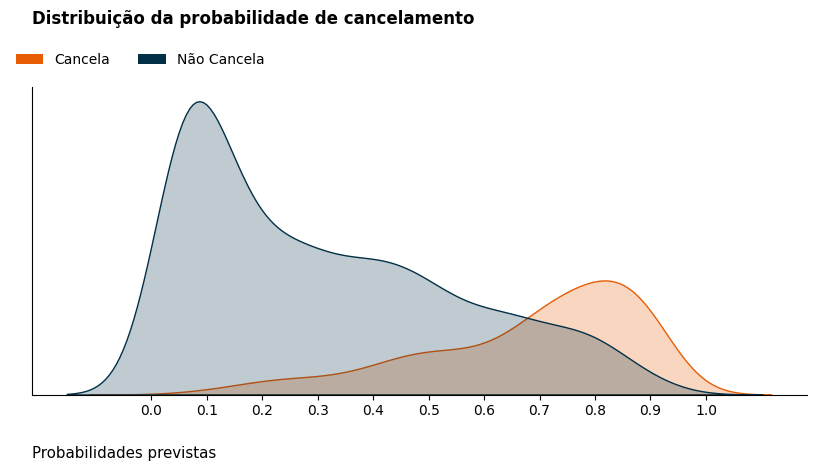

In [9]:
plot_probability_distributions(y_test, churn_probas)

**Por default o threshold é 0.5**

#### Feature Importances

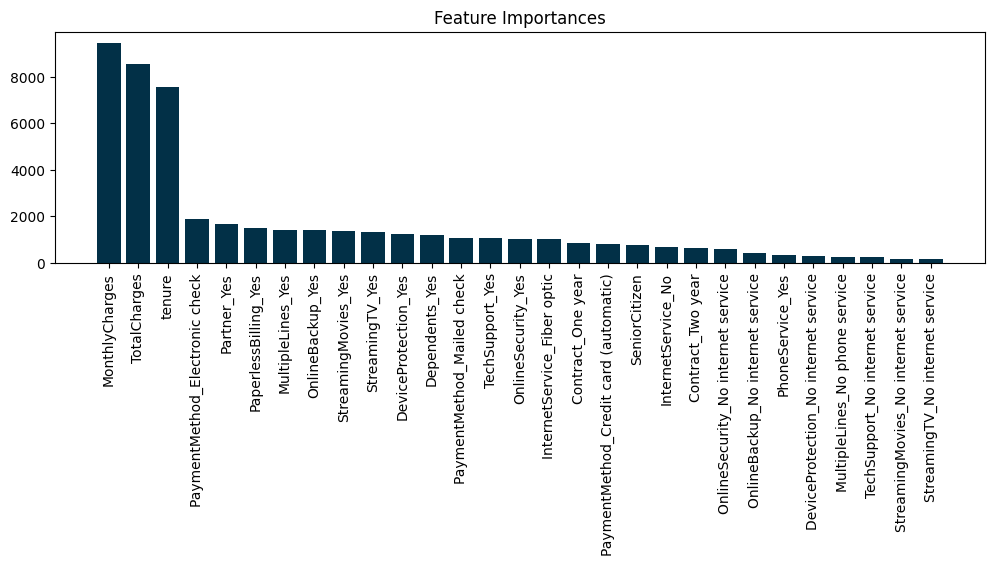

In [10]:
plot_feature_importances(lgb_clf, X_train)

#### Salvando o Modelo

In [39]:
# Salvando o modelo em um arquivo pickle
lgb_clf_path = os.path.join(os.pardir, 'models', 'lgb_clf.pkl')
save_object(lgb_clf_path, lgb_clf)

# Carrega o modelo salvo 
#lgb_clf = pickle.load(open('../models/lgb_clf.pkl', 'rb'))

In [50]:
# Salvando os conjuntos de dados processados para o treinamento e avaliação
df_train.to_csv('../data/processed/df_train.csv', index=False)
df_test.to_csv('../data/processed/df_test.csv', index=False)

### Resultados financeiros

Expressarei o desempenho do modelo em termos de resultados financeiros para a empresa, a fim de mostrar que o projeto vale a pena. Farei isso observando a matriz de confusão e nossos dados atuais. Vamos supor que para os clientes que o modelo de machine learning identificar um possivel cancelamento, iremos oferecer um desconto de 7% para tentar rete-los.

**1. Custo de retenção por cliente (falso positivo):<br>**
Esse custo se aplica a clientes que não iriam churn, mas foram classificados erroneamente como churners pelo modelo, levando a empresa a oferecer 7% de desconto no serviço para tentar retê-los.


**2. Perda de receita por churner (falso negativo):<br>**
Esse custo surge quando os clientes que realmente vão cancelar o serviço não são identificados corretamente pelo modelo, levando a perda desses clientes e a receita associada. 


**3. Ganho financeiro com a retenção de um cliente corretamente previsto como churner (verdadeiro positivo):<br>**
Esse ganho ocorre quando o modelo prevê com precisão um cancelamento, permitindo-nos a tentativa de retê-los junto com a receita que eles geram.

In [12]:
financial_results = pd.concat([X_test, y_test], axis=1)[['MonthlyCharges', 'Churn']]
financial_results['predicted'] = y_pred

In [102]:
# Coluna com o desconto de 7% nos clientes Falso Positivos e True Positivos
financial_results['discount'] = np.where(
    (financial_results['Churn'] == 1) & (financial_results['predicted'] == 1),
    (7/100) * financial_results['MonthlyCharges'],  # 7% de desconto
    np.where(
        (financial_results['Churn'] == 0) & (financial_results['predicted'] == 1),
        (7/100) * financial_results['MonthlyCharges'],  # 7% de desconto
        np.where(
            (financial_results['Churn'] == 1) & (financial_results['predicted'] == 0),
            0,  # Não houve desconto
            np.where(
                (financial_results['Churn'] == 0) & (financial_results['predicted'] == 0),
                0,  # Não houve desconto
                financial_results['MonthlyCharges']
            )
        )
    )
)
financial_results['discount'] = financial_results['discount'].round(2)

In [107]:
# Valor da fatura mensal - o desconto de 7%.
financial_results['MonthlyChargesDiscount'] = financial_results['MonthlyCharges'] - financial_results['discount']

# Ajuste na posição das colunas
financial_results = financial_results[['MonthlyCharges', 'discount', 'MonthlyChargesDiscount', 'Churn', 'predicted']]

In [132]:
financial_results

,MonthlyCharges,discount,MonthlyChargesDiscount,Churn,predicted
0,69.05,0.00,69.05,0,0
1,64.20,0.00,64.20,0,0
2,78.35,0.00,78.35,0,0
3,94.00,6.58,87.42,0,1
4,79.85,5.59,74.26,1,1
...,...,...,...,...,...
1403,74.80,0.00,74.80,0,0
1404,89.85,6.29,83.56,0,1
1405,75.45,5.28,70.17,1,1
1406,54.75,0.00,54.75,0,0


In [134]:
financial_results.to_excel('../data/output/financial_results.xlsx')

In [133]:
print('Valor que a empresa deixou de ganhar:', financial_results[(financial_results['Churn'] == 0) & (financial_results['predicted'] == 1)]['discount'].sum())
print('Oferecemos um desconto de 7% a um cliente que não iria cancelar o serviço.')

Valor que a empresa deixou de ganhar: 1206.23
Oferecemos um desconto de 7% a um cliente que não iria cancelar o serviço.


In [126]:
discount_true_positive = financial_results[(financial_results['Churn'] == 1) & (financial_results['predicted'] == 1)]['discount'].sum()
save_money = financial_results[(financial_results['Churn'] == 1) & (financial_results['predicted'] == 1)]['MonthlyCharges'].sum()
print(f'Gastamos: {discount_true_positive} oferecendo 7% de desconto para não perder {save_money:.2f}.')

Gastamos: 1606.78 oferecendo 7% de desconto para não perder 22952.95.


In [129]:
lose_money = financial_results[(financial_results['Churn'] == 1) & (financial_results['predicted'] == 0)]['MonthlyCharges'].sum()
print(f'Perdemos: {lose_money:.2f}, pois o modelo não conseguiu identificar o cancelamento do serviço.')

Perdemos: 4588.15, pois o modelo não conseguiu identificar o cancelamento do serviço.


### Conclusão

- **Deixamos de arrecadar:** R$ 2.813,01 em descontos.
- **Perdemos:** R$ 4.588,15, pois não conseguimos prever. O que corresponde a 4.8% do total de clientes.
- **Salvamos:** R$ 22.952,94, pois conseguimos prever e suponhamos que tivemos êxito em reverter. O que corresponde a 21.7% do total de clientes.
- **O modelo identifica corretamente 82% dos clientes que cancelaram o serviço.**
